In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.tsa.seasonal import STL

In [2]:
'''
Load Data
'''
dataset = pd.read_csv(r'../data/processed/charity_main_cleaned.csv')

Preprocessing

In [3]:
'''
Preprocess Dates
Make sure dates are in datetime format and extract year, month, and financial year.
'''
# Define function to get financial year
def get_financial_year(date):
    if pd.isna(date):
        return np.nan
    return date.year if date.month >= 4 else date.year - 1

# Ensure dates are in datetime
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

dataset['registration_year'] = dataset['date_of_registration'].dt.to_period('Y')
dataset['removal_year'] = dataset['date_of_removal'].dt.to_period('Y')

dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

dataset['registration_fy'] = dataset['date_of_registration'].apply(get_financial_year)
dataset['removal_fy'] = dataset['date_of_removal'].apply(get_financial_year)

In [4]:
'''
Clean up charity classification descriptions.
This will create binary columns for each classification type.
'''
# Drop rows with missing classification
classification_df = dataset[['registered_charity_number', 'classification_description']].dropna()

# Create binary indicator for each classification
classification_df['value'] = 1

# Pivot to wide format with binary columns
classification_dummies = classification_df.pivot_table(
    index='registered_charity_number',
    columns='classification_description',
    values='value',
    aggfunc='max',
    fill_value=0
).astype(int)

# Rename columns for consistency
classification_dummies.columns = [
    f"classification_{str(col).replace(' ', '_').replace('-', '_').lower()}"
    for col in classification_dummies.columns
]

# Reset index and merge with original dataset
classification_dummies = classification_dummies.reset_index()
dataset = dataset.drop_duplicates(subset='registered_charity_number')  # ensure one row per charity
dataset = dataset.merge(classification_dummies, on='registered_charity_number', how='left')

# Set classification dummy columns start with 'classification_'
category_cols = [col for col in dataset.columns if col.startswith('classification_') and col != 'classification_description']

# Fill NaNs with 0 and convert to int to get 0/1 instead of 0.0/1.0
dataset[category_cols] = dataset[category_cols].fillna(0).astype(int)

Exploratory Analysis

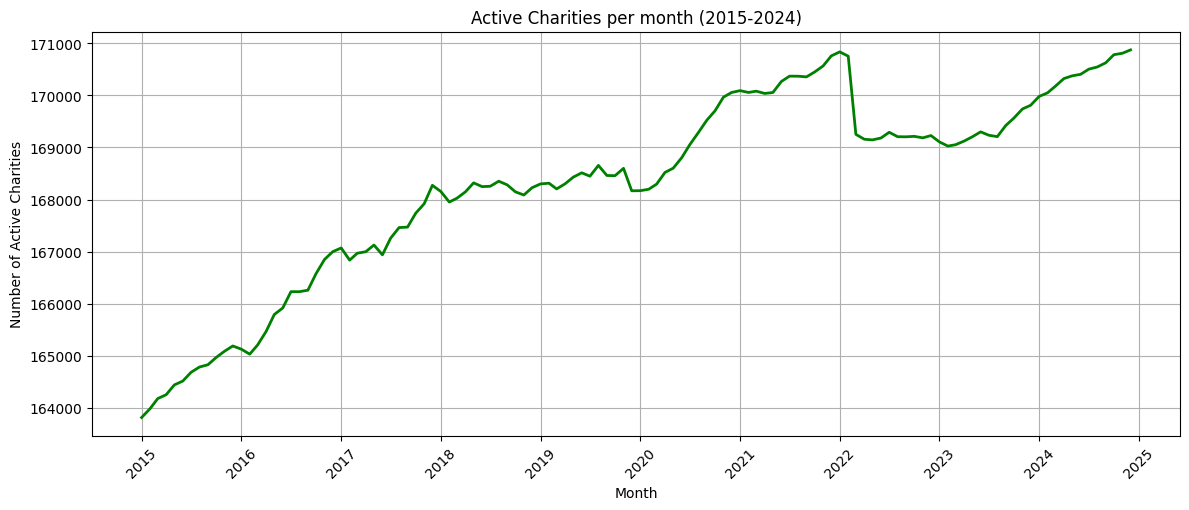

In [5]:
'''
Plot active charities
This will show the number of active charities each month from 2015 to 2024.
'''
# Monthly period range
all_months = pd.period_range(start='2015-01', end='2024-12', freq='M')

# Calculate active charities at each month-end
population_by_month = []
for month in all_months:
    active = dataset[
        (dataset['registration_month'] <= month) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month))
    ]
    population_by_month.append({'month': month, 'active': len(active)})

population_df = pd.DataFrame(population_by_month).set_index('month')

# Plot active charities
plt.figure(figsize=(12, 5))
plt.plot(population_df.index.to_timestamp(), population_df['active'], linewidth=2, color='green')
plt.title('Active Charities per month (2015-2024)')
plt.xlabel('Month')
plt.ylabel('Number of Active Charities')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

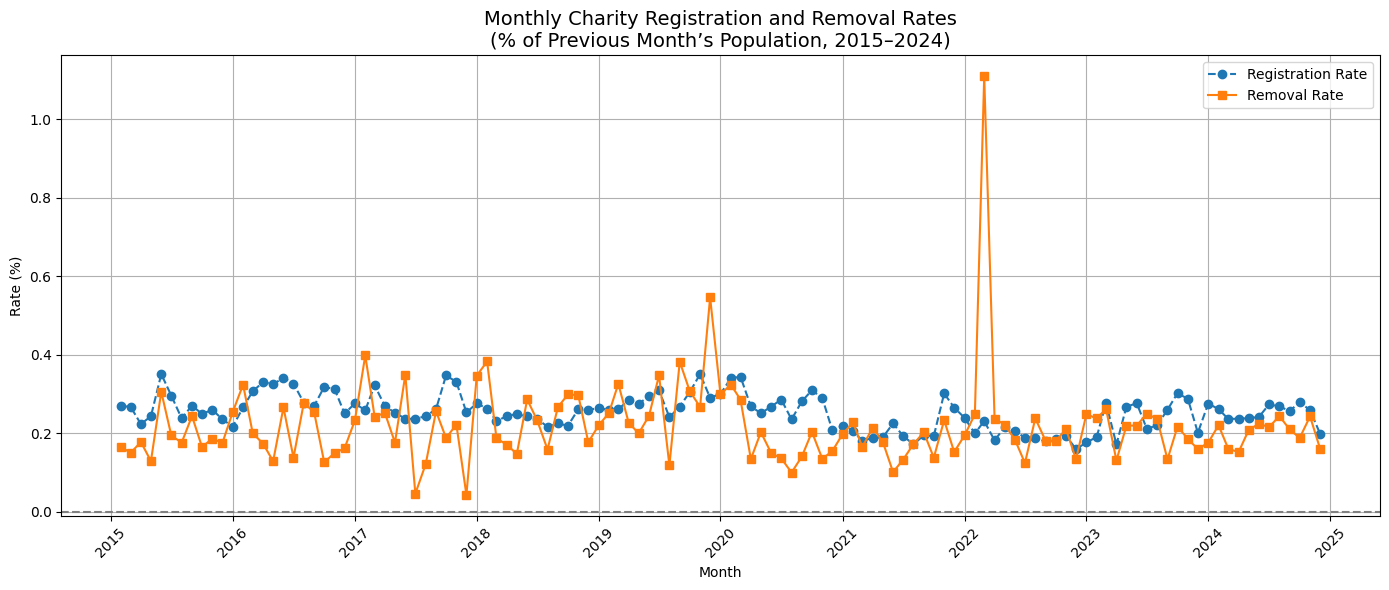

In [6]:
'''
Plot registration/removal rates
This will show the monthly registration and removal rates as a percentage of the previous month's active charities.
'''
# Count registrations and removals per month
registered = dataset['registration_month'].value_counts().sort_index()
removed = dataset['removal_month'].value_counts().sort_index()

# Ensure full alignment with all months
registered = registered.reindex(all_months, fill_value=0)
removed = removed.reindex(all_months, fill_value=0)

# Compute rates
population_df['prev_population'] = population_df['active'].shift(1).astype('Int64')
population_df['registered'] = registered
population_df['removed'] = removed
population_df['registration_rate'] = (population_df['registered'] / population_df['prev_population']) * 100
population_df['removal_rate'] = (population_df['removed'] / population_df['prev_population']) * 100

# Plot registration/removal rates
plt.figure(figsize=(14, 6))
plt.plot(population_df.index.to_timestamp(), population_df['registration_rate'], marker='o', linestyle='--', label='Registration Rate')
plt.plot(population_df.index.to_timestamp(), population_df['removal_rate'], marker='s', linestyle='-', label='Removal Rate')
plt.title('Monthly Charity Registration and Removal Rates\n(% of Previous Month’s Population, 2015–2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

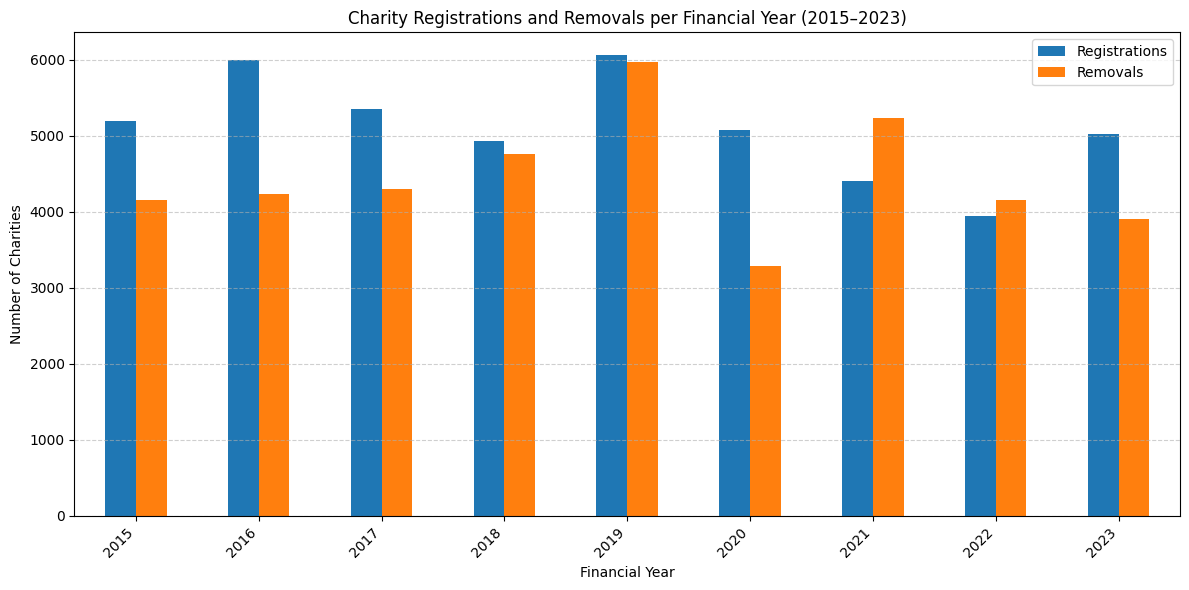

In [7]:
'''
Plot registrations and removals per month
This will show the number of registrations and removals each month from 2015 to 2024.
'''
# Filter Financial Year range
fy_min, fy_max = 2015, 2023

# Count registrations per FY
reg_counts = (
    dataset.dropna(subset=['registration_fy'])
    .groupby('registration_fy')
    .size()
    .rename('Registrations')
)

# Count removals per Financial Year
rem_counts = (
    dataset.dropna(subset=['removal_fy'])
    .groupby('removal_fy')
    .size()
    .rename('Removals')
)

# Combine into one DataFrame
fy_df = pd.concat([reg_counts, rem_counts], axis=1).fillna(0).astype(int)

# Restrict to 2015–2024 FYs
fy_df = fy_df.loc[(fy_df.index >= fy_min) & (fy_df.index <= fy_max)]

# Plot grouped bar chart
fy_df.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Charity Registrations and Removals per Financial Year (2015–2023)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='')
plt.tight_layout()
plt.show()


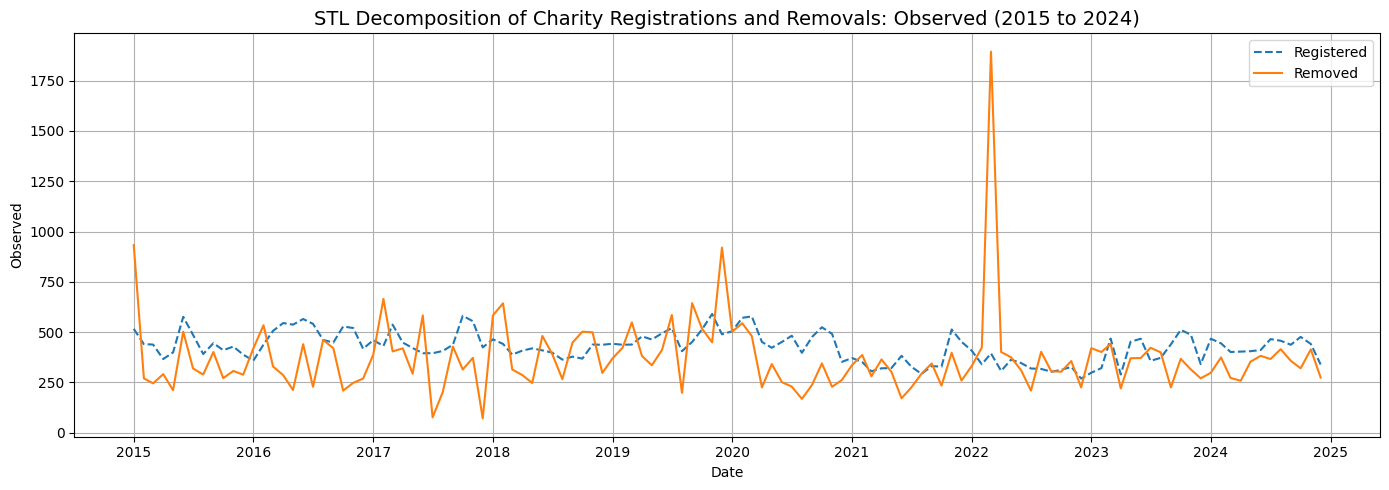

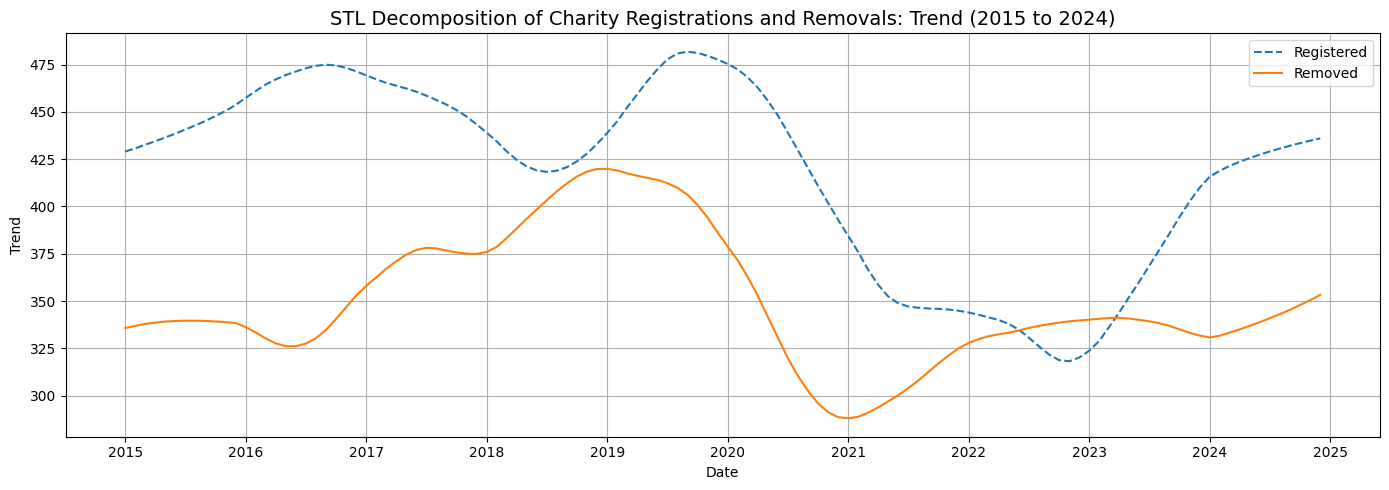

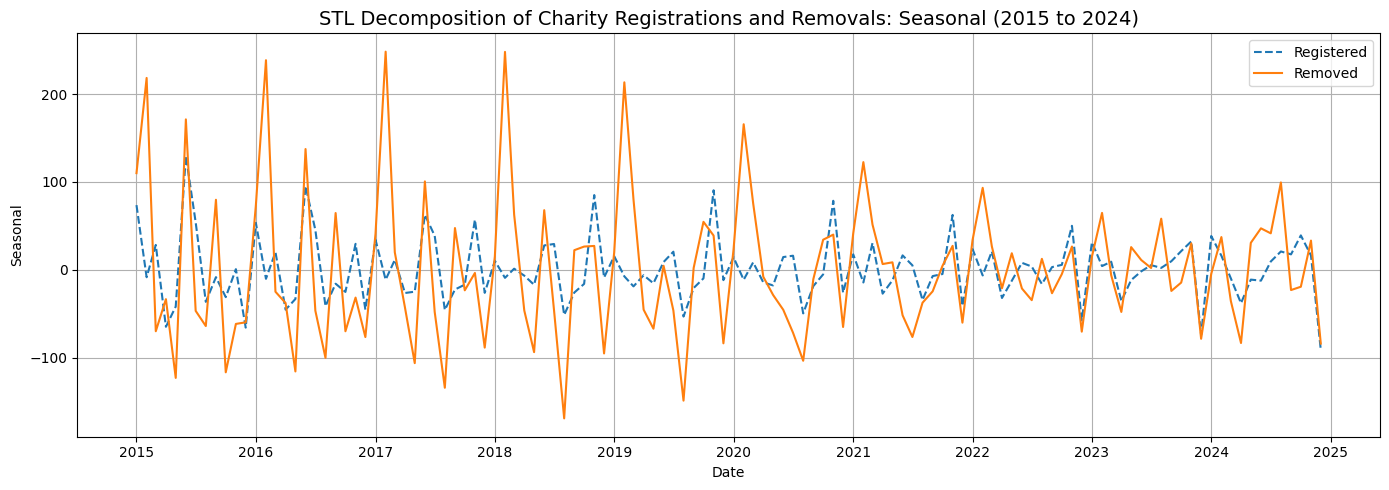

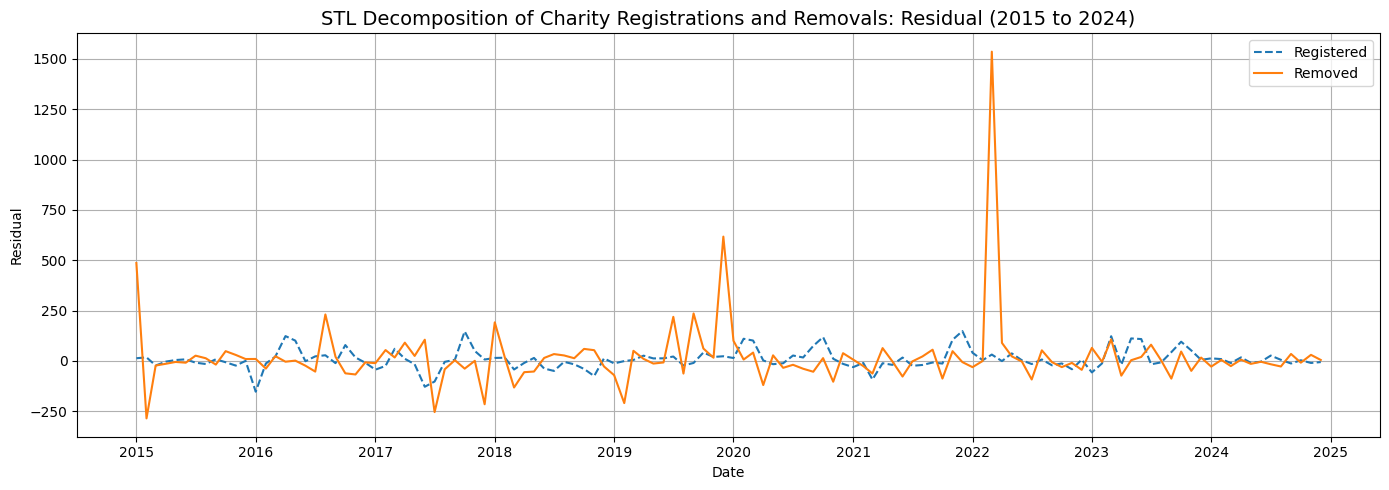

In [8]:
'''
Plot STL decomposition of registrations and removals
This will show the seasonal, trend, and residual components of registrations and removals.
'''
# Define full monthly range
monthly_range = pd.date_range(start='2015-01-01', end='2024-12-01', freq='MS')

# Aggregate registrations and removals to monthly counts
def count_monthly(series, monthly_range):
    return (
        series.value_counts()
        .sort_index()
        .reindex(monthly_range.to_period('M'), fill_value=0)
        .to_timestamp()
    )

registered_by_month = count_monthly(dataset['registration_month'], monthly_range)
removed_by_month = count_monthly(dataset['removal_month'], monthly_range)

# STL decomposition with auto-detection
def apply_stl(series):
    return STL(series, robust=True).fit()  # Let it auto-detect the period

stl_reg = apply_stl(registered_by_month)
stl_rem = apply_stl(removed_by_month)

# Plot each STL component in a separate graph
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residual']
colors = {'Registered': '#1f77b4', 'Removed': '#ff7f0e'}

for comp, title in zip(components, titles):
    plt.figure(figsize=(14, 5))  # Larger size for individual plots
    plt.plot(getattr(stl_reg, comp), label='Registered', color=colors['Registered'], linestyle='--')
    plt.plot(getattr(stl_rem, comp), label='Removed', color=colors['Removed'], linestyle='-')
    plt.title(f'STL Decomposition of Charity Registrations and Removals: {title} (2015 to 2024)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


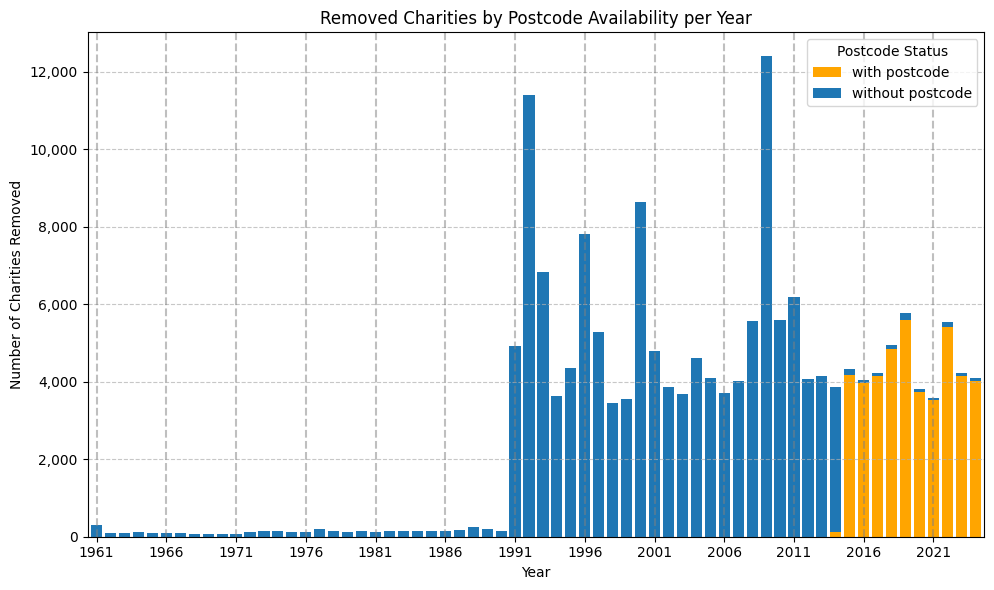

In [9]:
'''
Plot removed charities by postcode availability per year
This will show the number of removed charities each year, categorised by whether they had a postcode.
'''
# Preprocessing
removed = dataset[dataset['date_of_removal'].notnull()].copy()

def classify_postcode(x):
    if pd.isnull(x):
        return 'without postcode'
    x_str = str(x).strip().lower()
    return 'with postcode' if x_str not in ['', 'nan', 'none'] else 'without postcode'

removed['postcode_status'] = removed['postcode'].apply(classify_postcode)
removed['removal_year'] = removed['date_of_removal'].dt.year

removed_by_year_postcode = (
    removed.groupby(['removal_year', 'postcode_status'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Filter to 2024, excluding 2025
removed_by_year_postcode = removed_by_year_postcode.loc[removed_by_year_postcode.index <= 2024]

# Plot
ax = removed_by_year_postcode.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color={'with postcode': 'orange', 'without postcode': '#1f77b4'},
    width=0.8
)

plt.title('Removed Charities by Postcode Availability per Year')
plt.xlabel('Year')
plt.ylabel('Number of Charities Removed')

# X-ticks: show only every 5th year
years = removed_by_year_postcode.index
tick_positions = np.arange(len(years))
show_ticks = [i for i, y in enumerate(years) if (y - years.min()) % 5 == 0]

ax.set_xticks(show_ticks)
ax.set_xticklabels([years[i] for i in show_ticks], rotation=0)

# Add dashed vertical gridlines at those tick positions
for pos in show_ticks:
    ax.axvline(x=pos, color='grey', linestyle='--', alpha=0.5)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Postcode Status')
plt.tight_layout()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


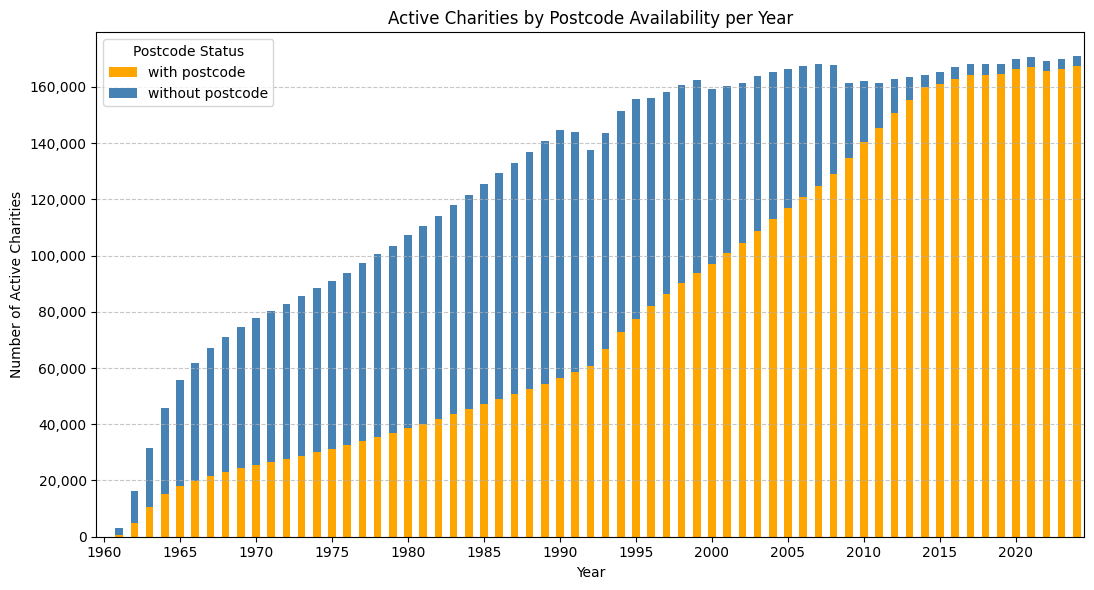

In [10]:
'''
Plot active charities by postcode availability per year
This will show the number of active charities each year, categorised by whether they had a postcode
'''
# Postcode classification
def classify_postcode(x):
    if pd.isnull(x):
        return 'without postcode'
    s = str(x).strip().lower()
    return 'with postcode' if s not in ['', 'nan', 'none'] else 'without postcode'

dataset['postcode_status'] = dataset['postcode'].apply(classify_postcode)

# Extract years
dataset['reg_year'] = dataset['date_of_registration'].dt.year
dataset['rem_year'] = dataset['date_of_removal'].dt.year

# Define year range
min_year = int(dataset['reg_year'].min())
max_year = 2024
years = list(range(min_year, max_year + 1))

# Count active charities per year
active_counts = []
for y in years:
    mask = (dataset['reg_year'] <= y) & (
        dataset['rem_year'].isna() | (dataset['rem_year'] > y)
    )
    counts = (
        dataset.loc[mask]
        .groupby('postcode_status')
        .size()
        .reindex(['with postcode', 'without postcode'], fill_value=0)
    )
    active_counts.append({
        'year': y,
        'with postcode': counts['with postcode'],
        'without postcode': counts['without postcode']
    })

active_df = pd.DataFrame(active_counts).set_index('year')

# Plot
ax = active_df[['with postcode', 'without postcode']].plot(
    kind='bar', stacked=True, color=['orange', 'steelblue'], figsize=(11, 6)
)

plt.title('Active Charities by Postcode Availability per Year')
plt.xlabel('Year')
plt.ylabel('Number of Active Charities')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Postcode Status')

# Show only 5-year ticks on x-axis
all_years = active_df.index
tick_positions = np.arange(len(all_years))
show_ticks = [i for i, y in enumerate(all_years) if y % 5 == 0]

ax.set_xticks(show_ticks)
ax.set_xticklabels([all_years[i] for i in show_ticks], rotation=0)

plt.tight_layout()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()


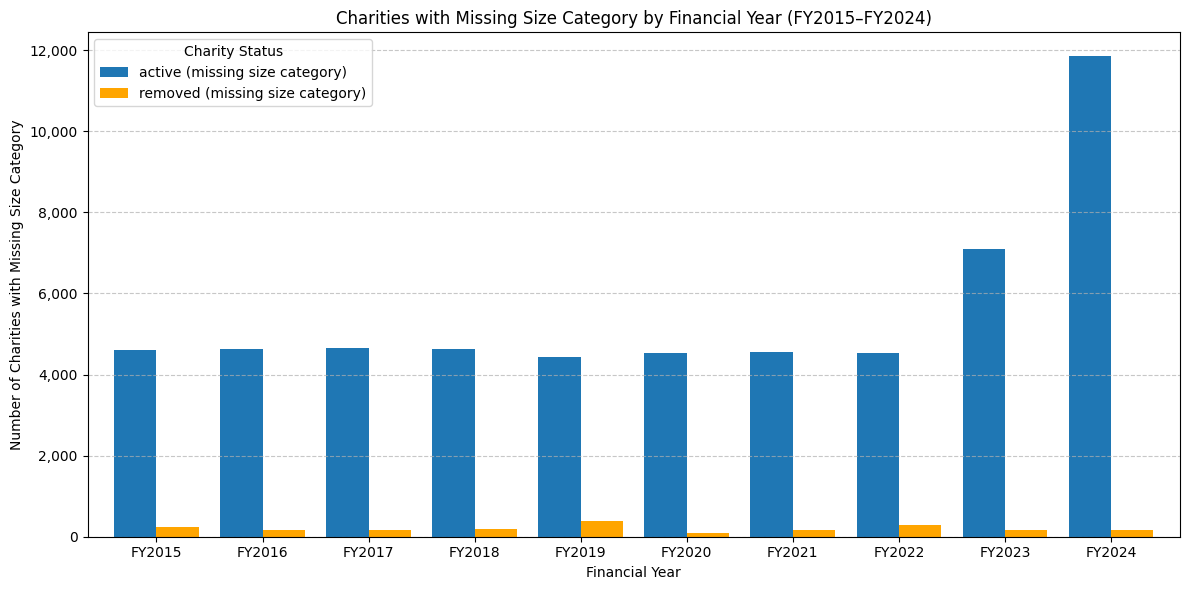

In [11]:
'''
Plot charities with missing size category
This will show the number of active and removed charities with missing size category by financial year.
'''
# Ensure FY columns are numeric
dataset['registration_fy'] = pd.to_numeric(dataset['registration_fy'], errors='coerce').astype('Int64')
dataset['removal_fy'] = pd.to_numeric(dataset['removal_fy'], errors='coerce').astype('Int64')

# Removed charities with missing size category
removed = dataset[dataset['removal_fy'].notna()].copy()
removed = removed[removed['removal_fy'].between(2015, 2024)]
removed_missing = (
    removed[removed['size_category'].isna()]
    .groupby('removal_fy')
    .size()
    .reindex(range(2015, 2025), fill_value=0)
)

# Active charities with missing size category
active_missing_records = []
for y in range(2015, 2025):
    active = dataset[
        (dataset['registration_fy'].notna()) &
        (dataset['registration_fy'] <= y) &
        (dataset['removal_fy'].isna() | (dataset['removal_fy'] > y))
    ]
    null_count = active['size_category'].isna().sum()
    active_missing_records.append(null_count)

active_missing = pd.Series(active_missing_records, index=range(2015, 2025))

# Combine into one DataFrame
combined = pd.DataFrame({
    'active (missing size category)': active_missing,
    'removed (missing size category)': removed_missing
})
combined.index = [f'FY{y}' for y in combined.index]

# Plot
color_map = {
    'active (missing size category)': '#1f77b4',
    'removed (missing size category)': 'orange'
}

combined.plot(
    kind='bar',
    figsize=(12, 6),
    color=[color_map[c] for c in combined.columns],
    width=0.8
)

plt.title('Charities with Missing Size Category by Financial Year (FY2015–FY2024)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities with Missing Size Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(title='Charity Status')
plt.tight_layout()
plt.show()


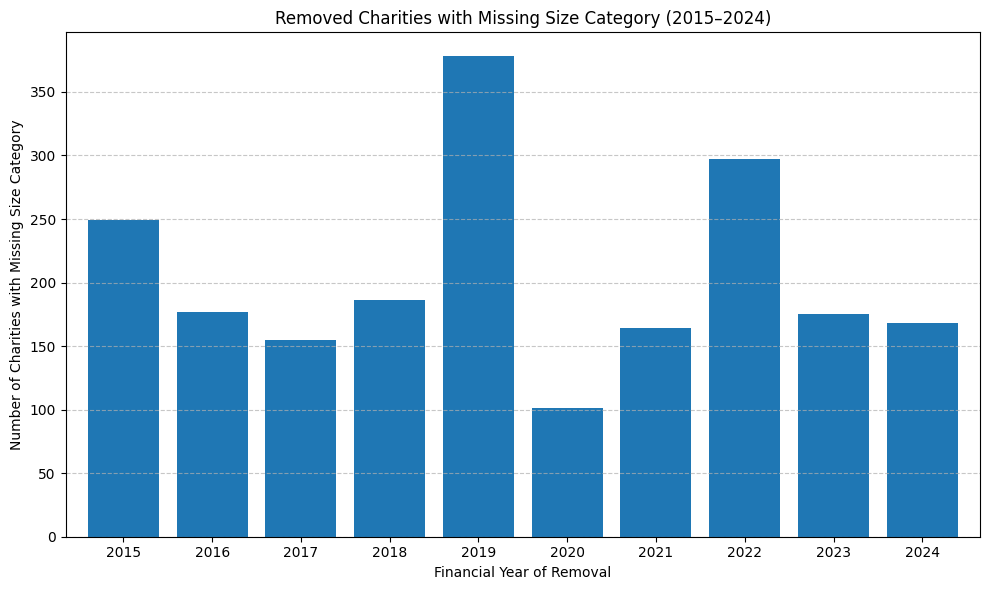

In [12]:
'''
Plot removed charities with missing size category
This will show the number of removed charities that have missing size category each year.
'''

# Filter only charities that have been removed
removed = dataset[dataset['removal_fy'].notna()].copy()

# Ensure correct data types
removed['removal_fy'] = removed['removal_fy'].astype(int)

# Filter to years of interest (optional, for focus)
removed = removed[removed['removal_fy'].between(2015, 2024)]

# Count how many removed charities had missing size category per year
missing_by_removal_year = (
    removed[removed['size_category'].isna()]
    .groupby('removal_fy')
    .size()
    .reindex(range(2015, 2025), fill_value=0)  # Ensure full range
)

# Plot
plt.figure(figsize=(10, 6))
missing_by_removal_year.plot(
    kind='bar',
    color='#1f77b4',
    width=0.8
)
plt.title('Removed Charities with Missing Size Category (2015–2024)')
plt.xlabel('Financial Year of Removal')
plt.ylabel('Number of Charities with Missing Size Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)  # keep year labels horizontal
plt.tight_layout()
plt.show()


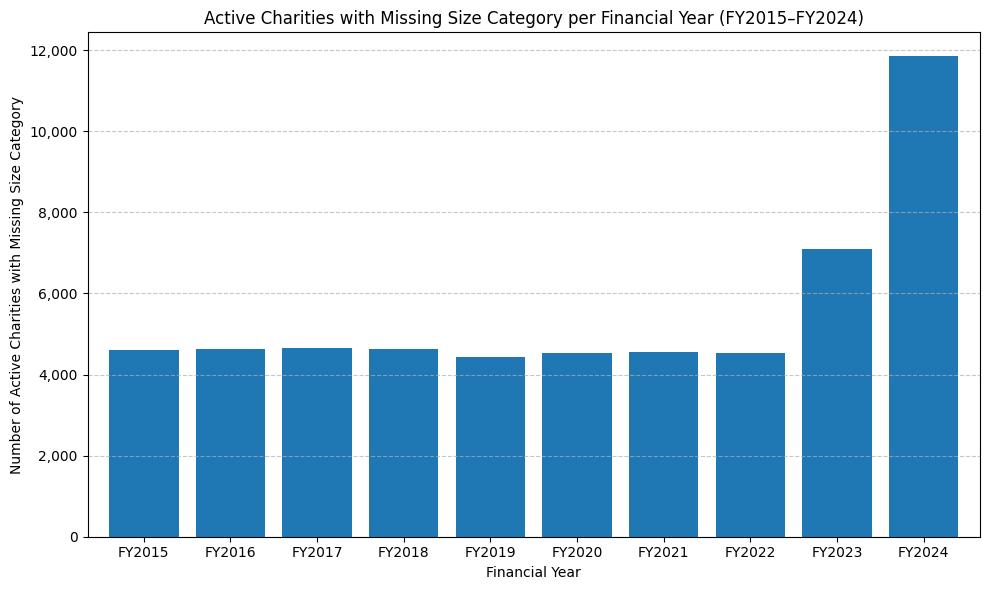

In [13]:
'''
Plot active charities with missing size category per financial year
This will show the number of active charities with missing size category by financial year.
'''

# Ensure FY columns are numeric
dataset['registration_fy'] = pd.to_numeric(dataset['registration_fy'], errors='coerce').astype('Int64')
dataset['removal_fy']     = pd.to_numeric(dataset['removal_fy'], errors='coerce').astype('Int64')

records = []
for y in range(2015, 2025):  # FY2015–FY2024
    active = dataset[
        (dataset['registration_fy'].notna()) &
        (dataset['registration_fy'] <= y) &
        (dataset['removal_fy'].isna() | (dataset['removal_fy'] > y))
    ]
    missing_size_count = active['size_category'].isna().sum()
    records.append({'FY': f'FY{y}', 'missing size_category': missing_size_count})

missing_size_by_fy = pd.DataFrame(records).set_index('FY')

# Plot

plt.figure(figsize=(10, 6))
missing_size_by_fy['missing size_category'].plot(
    kind='bar',
    color='#1f77b4',
    width=0.8
)
plt.title('Active Charities with Missing Size Category per Financial Year (FY2015–FY2024)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Active Charities with Missing Size Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()


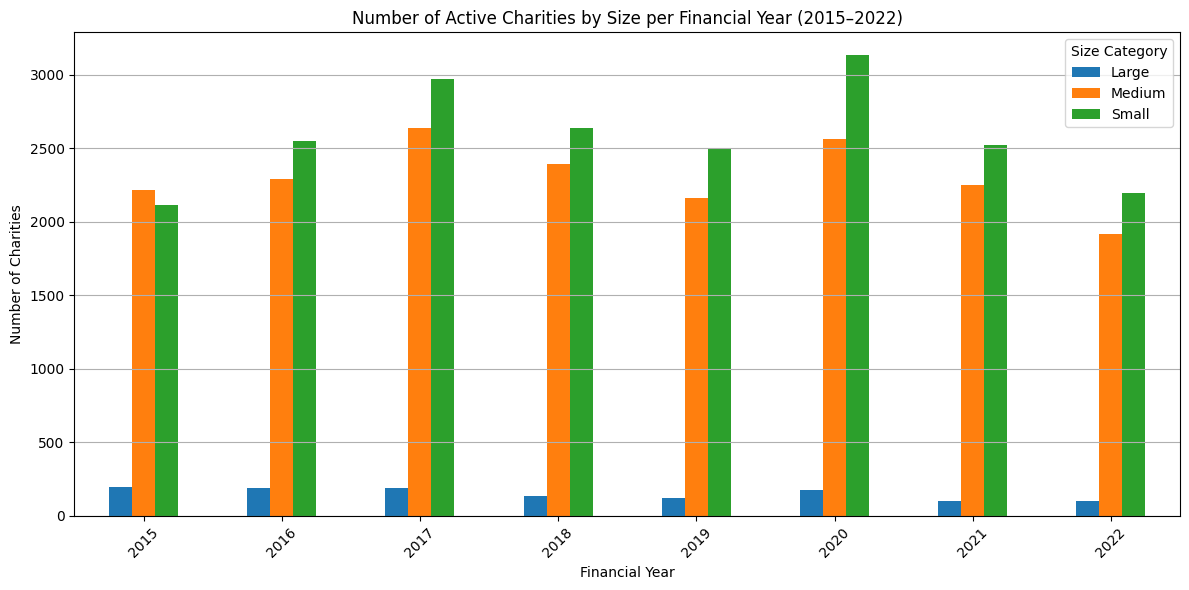

In [14]:
'''
Plot the number of active charities by size for each financial year (2015–2022)
This visualisation shows the annual count of active registered charities, grouped by size category.
From the earlier missing size category analysis, financial years 2023 and 2024 contain 
a higher proportion of active charities with unknown size, which could bias the results.
Therefore, only data up to the 2022 financial year is included.
'''
# Extract financial year from registration date (FY starts in April)
dataset['registration_fy'] = dataset['date_of_registration'].apply(
    lambda x: x.year if x.month < 4 else x.year + 1
)

# Filter to years 2015–2022
fy_counts = (
    dataset[dataset['registration_fy'].between(2015, 2022)]
    .groupby(['registration_fy', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

# Plot
ax = fy_counts.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Number of Active Charities by Size per Financial Year (2015–2022)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities')
plt.xticks(rotation=45)
plt.legend(title='Size Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

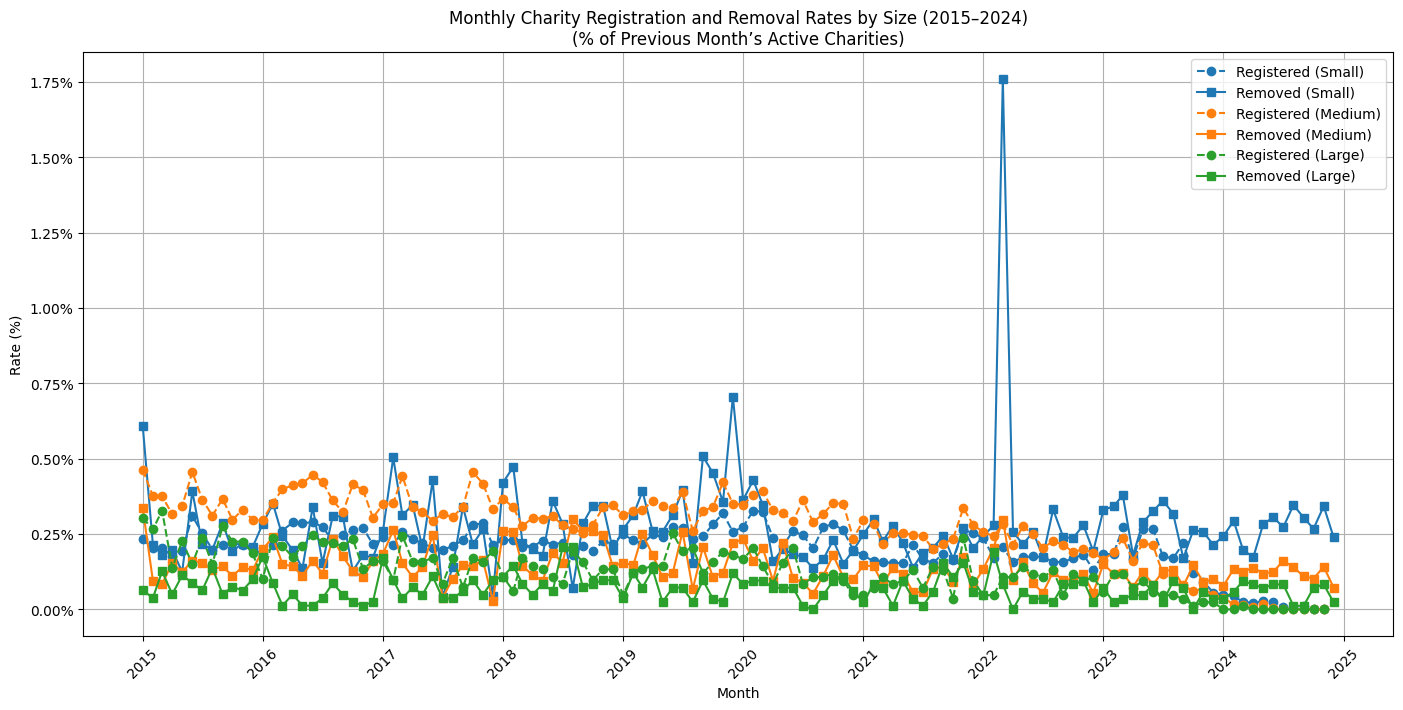

In [15]:
'''
Plot monthly charity registration and removal rates by size
This will show the registration and removal rates as a percentage of the previous month's active charities, 
categorised by size (Small, Medium, Large).
'''
# Define monthly period range
all_months = pd.period_range(start='2014-12', end='2024-12', freq='M')

# Ensure datetime columns and period columns exist
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

# Calculate registration and removal counts by size and month
registered_counts = (
    dataset[dataset['registration_month'].between('2015-01', '2024-12')]
    .groupby(['registration_month', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

removed_counts = (
    dataset[dataset['removal_month'].between('2015-01', '2024-12')]
    .groupby(['removal_month', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

# Calculate population at the start of each month
monthly_population = {}
for month in all_months[1:]:  # Start from 2015-01
    active = dataset[
        (dataset['registration_month'] <= month - 1) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month - 1))
    ]
    counts = active['size_category'].value_counts().to_dict()
    monthly_population[month] = counts

population_df = pd.DataFrame(monthly_population).T.fillna(0).astype(int)
population_df.index.name = 'month'

# Calculate percentage
reg_pct = (registered_counts.div(population_df) * 100).dropna()
rem_pct = (removed_counts.div(population_df) * 100).dropna()

# Convert index for plotting
reg_pct.index = reg_pct.index.to_timestamp()
rem_pct.index = rem_pct.index.to_timestamp()

# Plot
plt.figure(figsize=(14, 7))
colors = {'Small': 'tab:blue', 'Medium': 'tab:orange', 'Large': 'tab:green'}

for size in ['Small', 'Medium', 'Large']:
    if size in reg_pct.columns:
        plt.plot(reg_pct.index, reg_pct[size], linestyle='--', marker='o', color=colors[size], label=f'Registered ({size})')
    if size in rem_pct.columns:
        plt.plot(rem_pct.index, rem_pct[size], linestyle='-', marker='s', color=colors[size], label=f'Removed ({size})')

plt.title('Monthly Charity Registration and Removal Rates by Size (2015–2024)\n(% of Previous Month’s Active Charities)')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21956\2404653320.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['removal_fy', 'removal_age_group'])


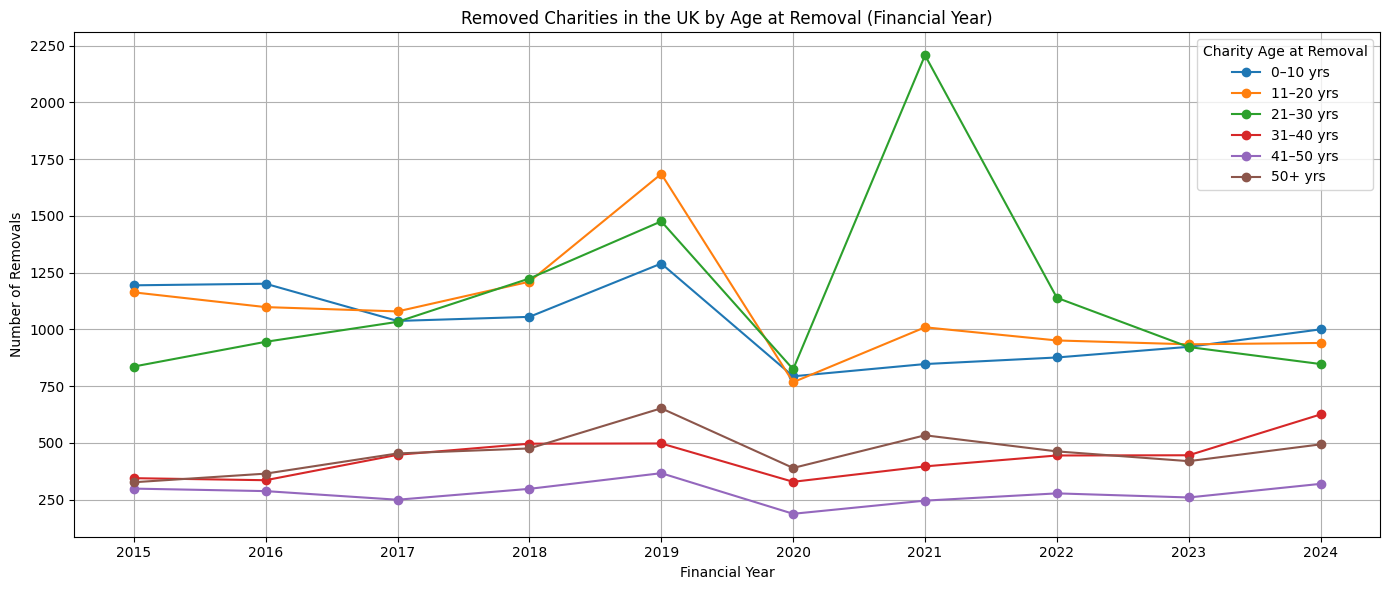

In [16]:
'''
Plot removed charities by age at removal
This will show the number of removed charities categorised by age at removal each financial year.
'''
# Calculate charity age at removal
dataset['age_at_removal'] = (
    dataset['date_of_removal'] - dataset['date_of_registration']
).dt.days // 365  # convert to approximate years

# Define age bins and labels
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
dataset['removal_age_group'] = pd.cut(dataset['age_at_removal'], bins=bins, labels=labels, right=False)

# Filter data to financial years of interest
filtered = dataset[dataset['removal_fy'].between(2015, 2024)]

# Group and count removals by FY and age group
removals_by_age_fy = (
    filtered.groupby(['removal_fy', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Plot
plt.figure(figsize=(14, 6))
for col in removals_by_age_fy.columns:
    plt.plot(removals_by_age_fy.index, removals_by_age_fy[col], marker='o', label=col)

plt.title('Removed Charities in the UK by Age at Removal (Financial Year)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Removals')
plt.legend(title='Charity Age at Removal')
plt.grid(True)
plt.tight_layout()
plt.xticks(removals_by_age_fy.index)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21956\2137660495.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['removal_fy', 'size_category', 'removal_age_group'])
C:\Users\User\AppData\Local\Temp\ipykernel_21956\2137660495.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped.pivot_table(index='removal_fy', columns=['size_category', 'removal_age_group'], values='count', fill_value=0)


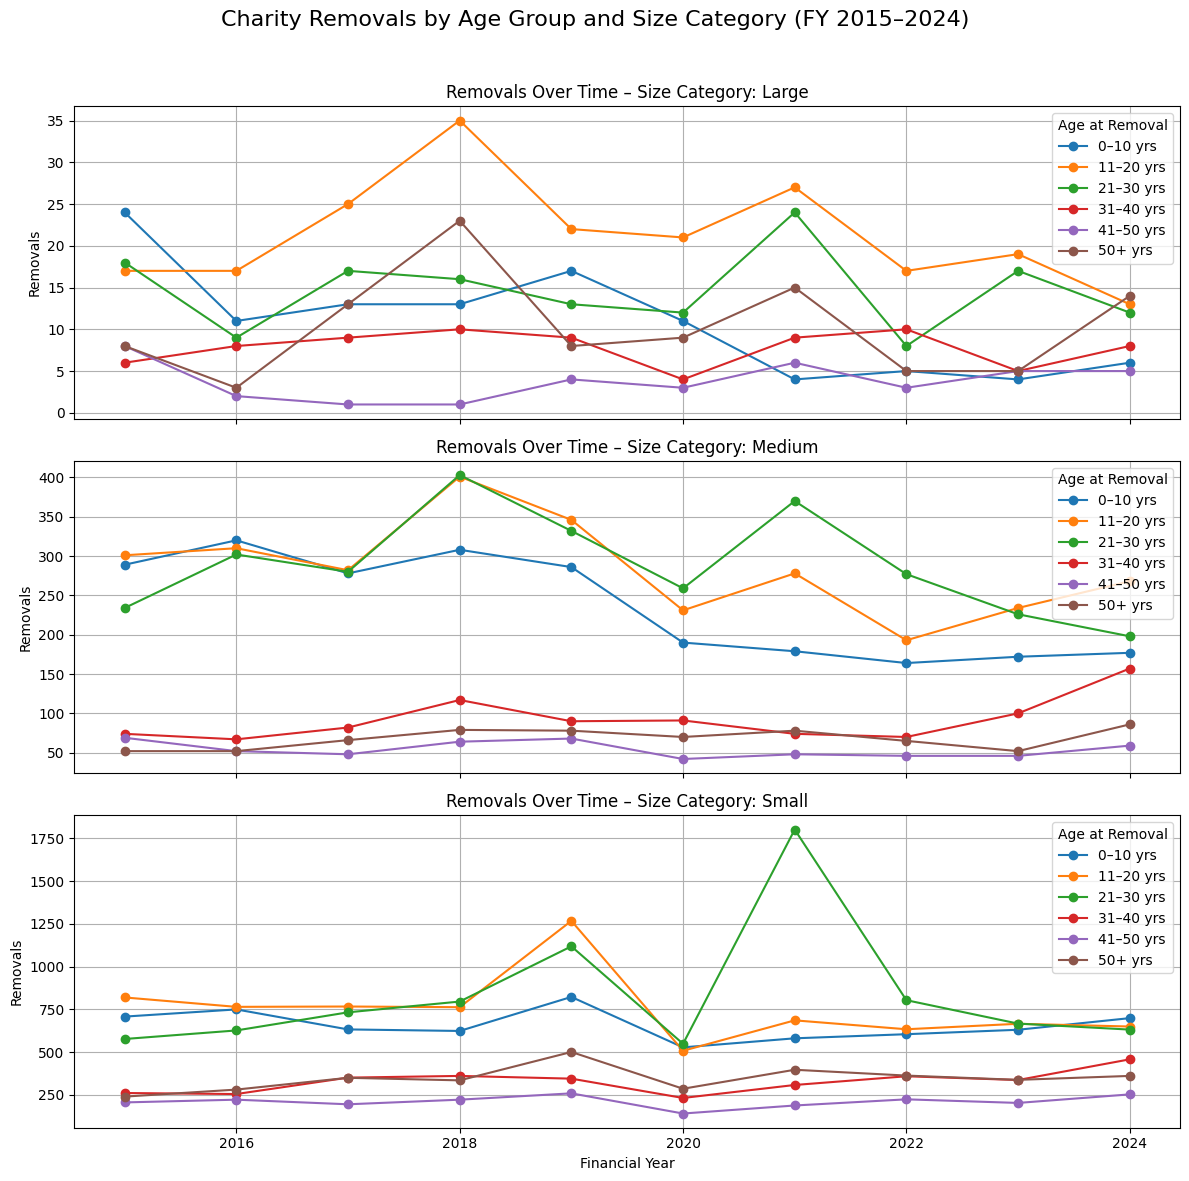

In [17]:
'''
Plot removals over time by age group and size category
This will show the number of removals over time, categorised by size and age group.
'''
# Bin age into groups
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
dataset['removal_age_group'] = pd.cut(dataset['age_at_removal'], bins=bins, labels=labels, right=False)

# Filter to valid data
filtered = dataset[
    dataset['removal_fy'].between(2015, 2024) &
    dataset['removal_age_group'].notna() &
    dataset['size_category'].notna()
]

# Group and pivot
grouped = (
    filtered.groupby(['removal_fy', 'size_category', 'removal_age_group'])
    .size()
    .reset_index(name='count')
)

pivoted = (
    grouped.pivot_table(index='removal_fy', columns=['size_category', 'removal_age_group'], values='count', fill_value=0)
)

# Plot
size_categories = pivoted.columns.get_level_values(0).unique()
age_groups = labels

fig, axs = plt.subplots(len(size_categories), 1, figsize=(12, 4 * len(size_categories)), sharex=True)

if len(size_categories) == 1:
    axs = [axs]  # make iterable if only one category

for i, size in enumerate(size_categories):
    ax = axs[i]
    for age in age_groups:
        try:
            ax.plot(pivoted.index, pivoted[size, age], marker='o', label=age)
        except KeyError:
            continue  # some age groups might be missing in smaller samples
    ax.set_title(f'Removals Over Time – Size Category: {size}')
    ax.set_ylabel('Removals')
    ax.legend(title='Age at Removal')
    ax.grid(True)

axs[-1].set_xlabel('Financial Year')
plt.suptitle('Charity Removals by Age Group and Size Category (FY 2015–2024)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_21956\1803796994.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)  # 'tab20' has 20 distinct colours, can switch to 'tab20b/tab20c'


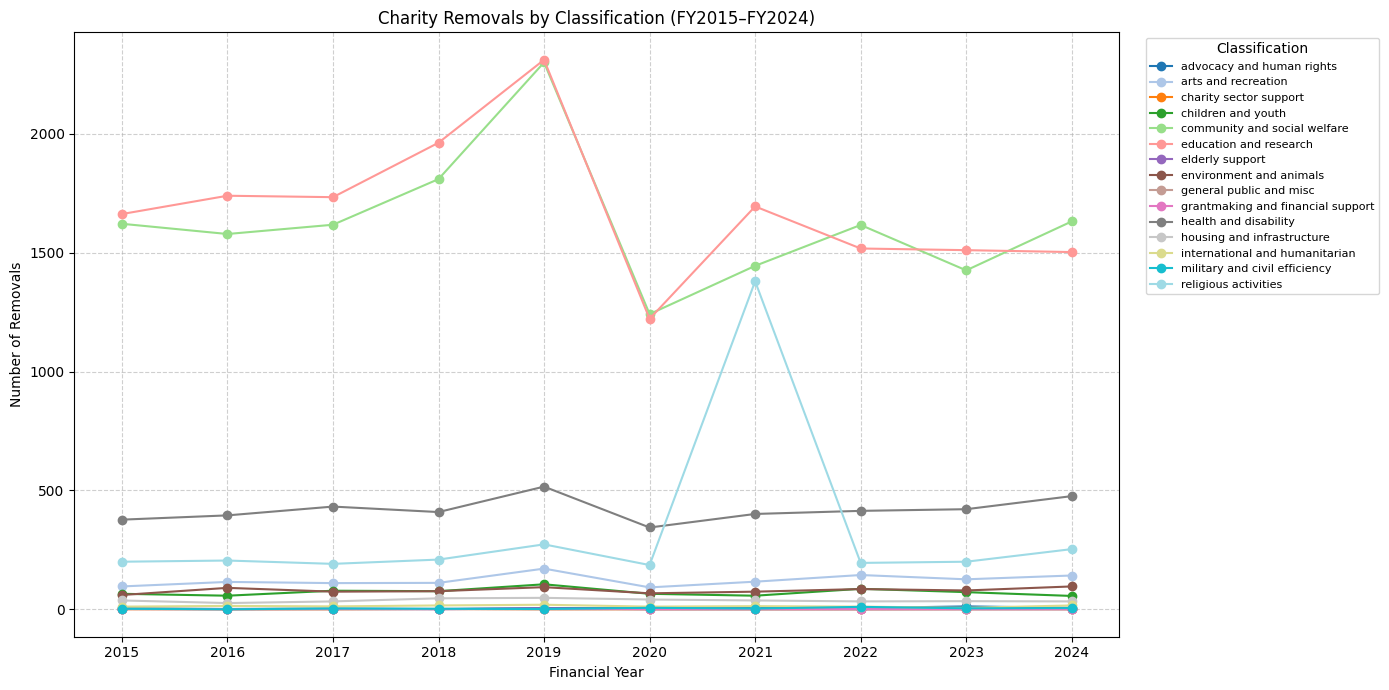

In [18]:
'''
Plot removed charities by classification
This will show the number of removed charities categorised by classification for each financial year.
'''
# Select classification_* columns but exclude description
class_cols = [
    c for c in dataset.columns 
    if c.startswith('classification_') and c != 'classification_description'
]

# Ensure FY column is numeric
dataset['removal_fy'] = pd.to_numeric(dataset['removal_fy'], errors='coerce').astype('Int64')

# Filter years of interest
filtered = dataset[dataset['removal_fy'].between(2015, 2024)].copy()

# Ensure classification columns are numeric (handles bools/NaNs)
filtered[class_cols] = filtered[class_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Build summary
summary = (
    filtered
    .groupby('removal_fy')[class_cols]
    .sum()
    .reindex(range(2015, 2025), fill_value=0)
)

# Generate unique colours
num_classes = len(summary.columns)
cmap = plt.cm.get_cmap('tab20', num_classes)  # 'tab20' has 20 distinct colours, can switch to 'tab20b/tab20c'

# Plot
plt.figure(figsize=(14, 7))
for i, col in enumerate(summary.columns):
    label_clean = col.replace('classification_', '').replace('_', ' ')
    plt.plot(
        summary.index, 
        summary[col], 
        marker='o', 
        linewidth=1.5, 
        label=label_clean,
        color=cmap(i)  # unique colour for each classification
    )

plt.title("Charity Removals by Classification (FY2015–FY2024)")
plt.xlabel("Financial Year")
plt.ylabel("Number of Removals")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(summary.index)
plt.legend(title="Classification", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_21956\3646598626.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


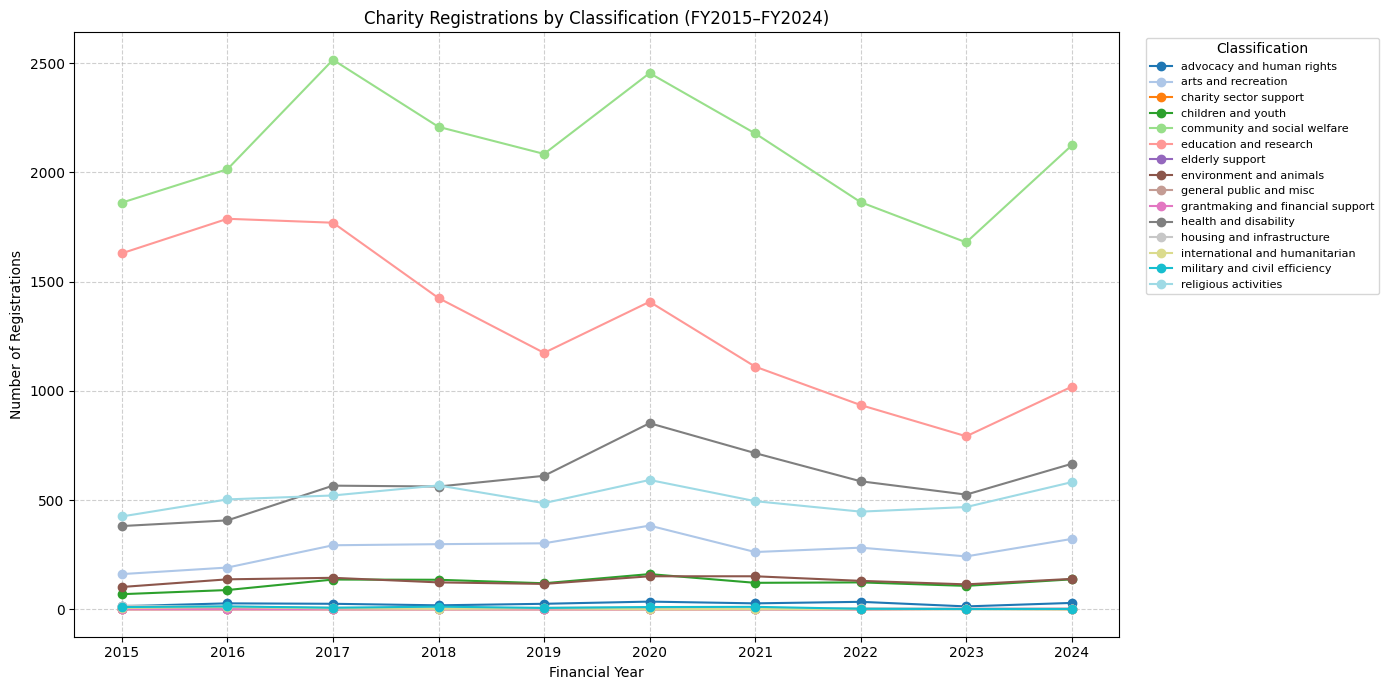

In [19]:
'''
Plot registrations by classification
This will show the number of registered charities categorised by classification for each financial year.
'''
# Select classification_* columns but exclude description
class_cols = [
    c for c in dataset.columns 
    if c.startswith('classification_') and c != 'classification_description'
]

# Ensure FY column is numeric
dataset['registration_fy'] = pd.to_numeric(dataset['registration_fy'], errors='coerce').astype('Int64')

# Filter relevant years
filtered = dataset[dataset['registration_fy'].between(2015, 2024)].copy()

# Ensure classification columns are numeric (binary 0/1)
filtered[class_cols] = filtered[class_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Build summary (sum of dummies per FY)
summary = (
    filtered
    .groupby('registration_fy')[class_cols]
    .sum()
    .reindex(range(2015, 2025), fill_value=0)
)

# Generate unique colours
num_classes = len(summary.columns)
cmap = plt.cm.get_cmap('tab20', num_classes)

# Plot
plt.figure(figsize=(14, 7))
for i, col in enumerate(summary.columns):
    label_clean = col.replace('classification_', '').replace('_', ' ')
    plt.plot(
        summary.index,
        summary[col],
        marker='o',
        linewidth=1.5,
        label=label_clean,
        color=cmap(i)  # unique colour
    )

plt.title("Charity Registrations by Classification (FY2015–FY2024)")
plt.xlabel("Financial Year")
plt.ylabel("Number of Registrations")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(summary.index)
plt.legend(title="Classification", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_21956\3433523155.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_series)


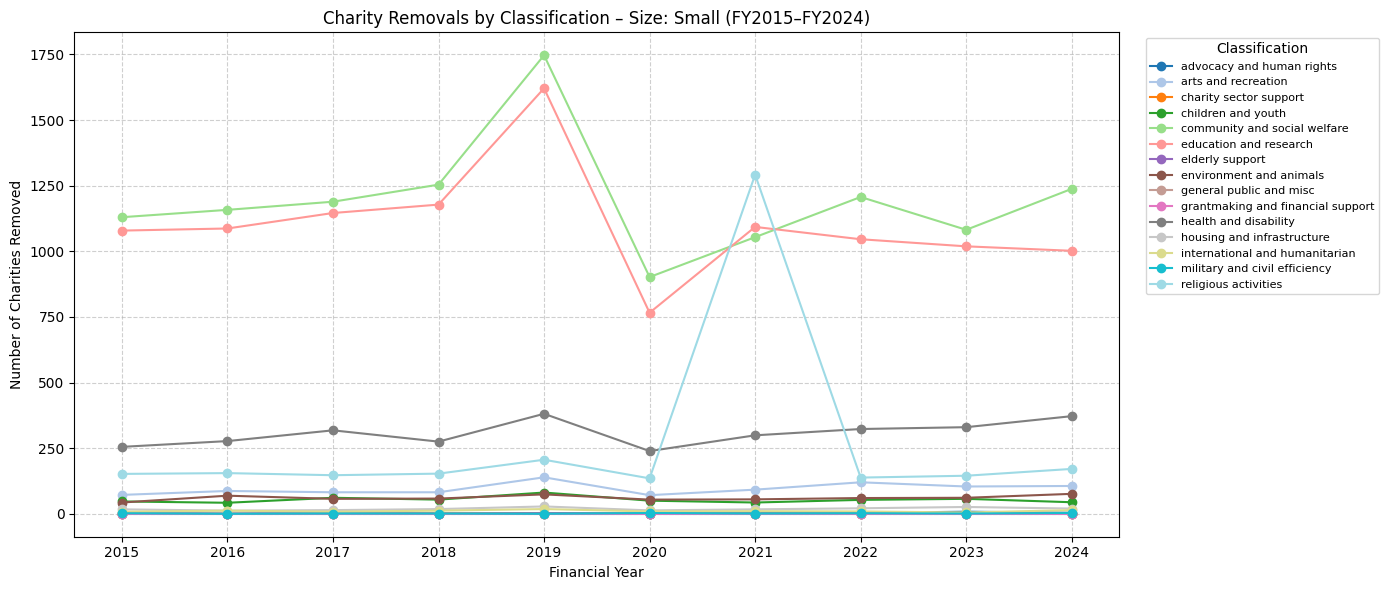

C:\Users\User\AppData\Local\Temp\ipykernel_21956\3433523155.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_series)


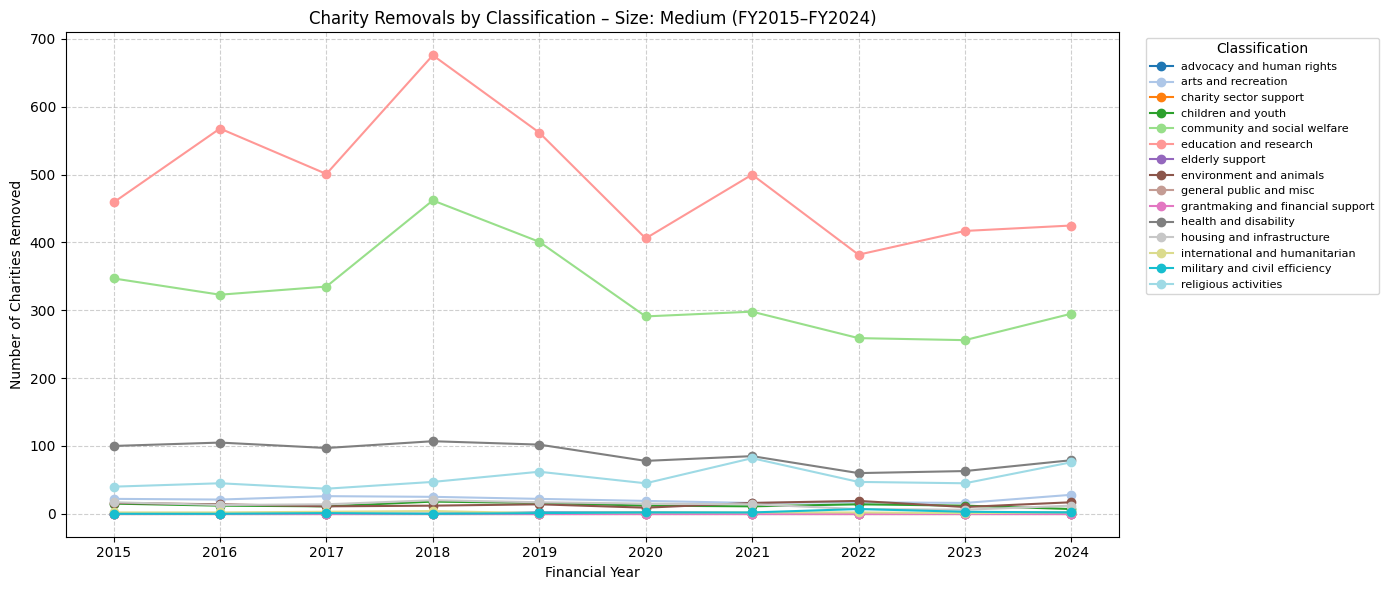

C:\Users\User\AppData\Local\Temp\ipykernel_21956\3433523155.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_series)


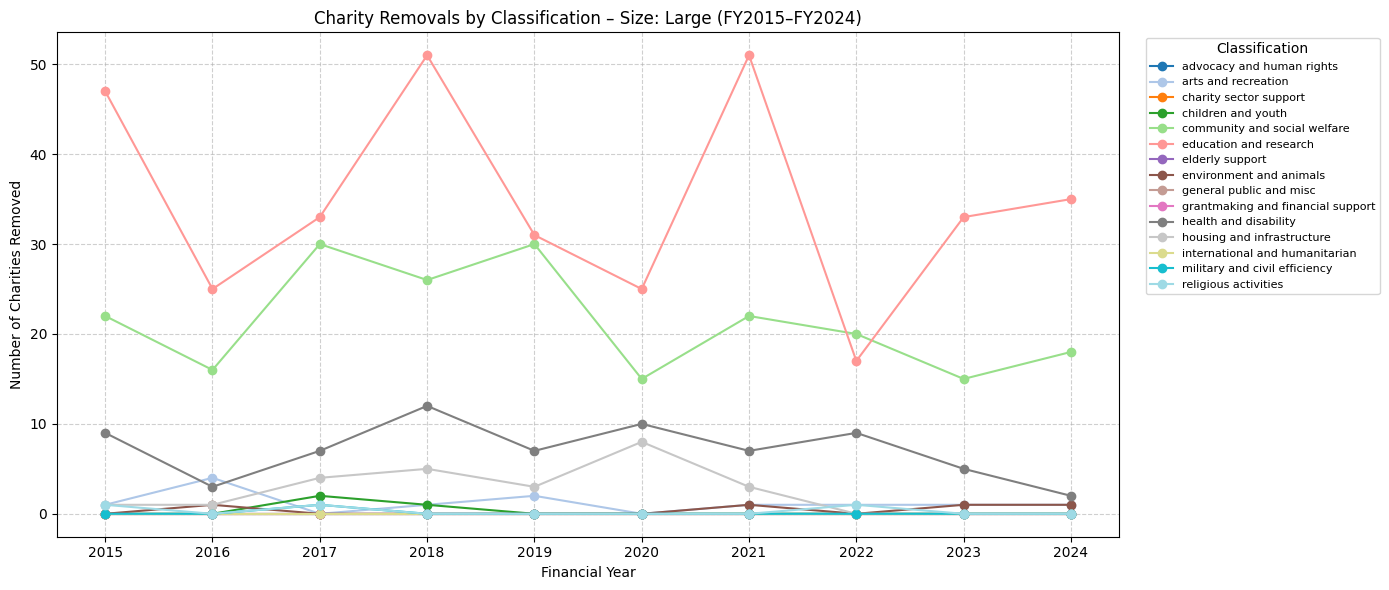

In [20]:
'''
Plot charity removals by classification and size
This will show the number of removed charities categorised by classification and size for each financial year.
'''
# Select classification_* columns but exclude the description field
class_cols = [
    c for c in dataset.columns
    if c.startswith('classification_') and c != 'classification_description'
]

# Ensure types
dataset['removal_fy'] = pd.to_numeric(dataset['removal_fy'], errors='coerce').astype('Int64')
# Coerce classification dummies to numeric (handles bools/NaNs)
dataset[class_cols] = dataset[class_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Financial years of interest
fy_index = range(2015, 2025)  # FY2015–FY2024

for size in ['Small', 'Medium', 'Large']:
    subset = dataset[
        (dataset['size_category'] == size) &
        (dataset['removal_fy'].between(2015, 2024))
    ].copy()

    # Sum of dummies per FY
    summary = (
        subset
        .groupby('removal_fy')[class_cols]
        .sum()
        .reindex(fy_index, fill_value=0)
    )

    # Unique colours (use tab20 if <=20 lines; otherwise sample a continuous cmap)
    num_series = len(summary.columns)
    if num_series <= 20:
        cmap = plt.cm.get_cmap('tab20', num_series)
        colors = [cmap(i) for i in range(num_series)]
    else:
        cmap = plt.cm.get_cmap('hsv', num_series)  # plenty of distinct hues
        colors = [cmap(i) for i in range(num_series)]

    # Plot
    plt.figure(figsize=(14, 6))
    for i, col in enumerate(summary.columns):
        label_clean = col.replace('classification_', '').replace('_', ' ')
        plt.plot(
            summary.index, summary[col],
            marker='o', linewidth=1.5,
            label=label_clean, color=colors[i]
        )

    plt.title(f"Charity Removals by Classification – Size: {size} (FY2015–FY2024)")
    plt.xlabel("Financial Year")
    plt.ylabel("Number of Charities Removed")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(list(fy_index))
    plt.legend(title="Classification", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_21956\1201124502.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_series)


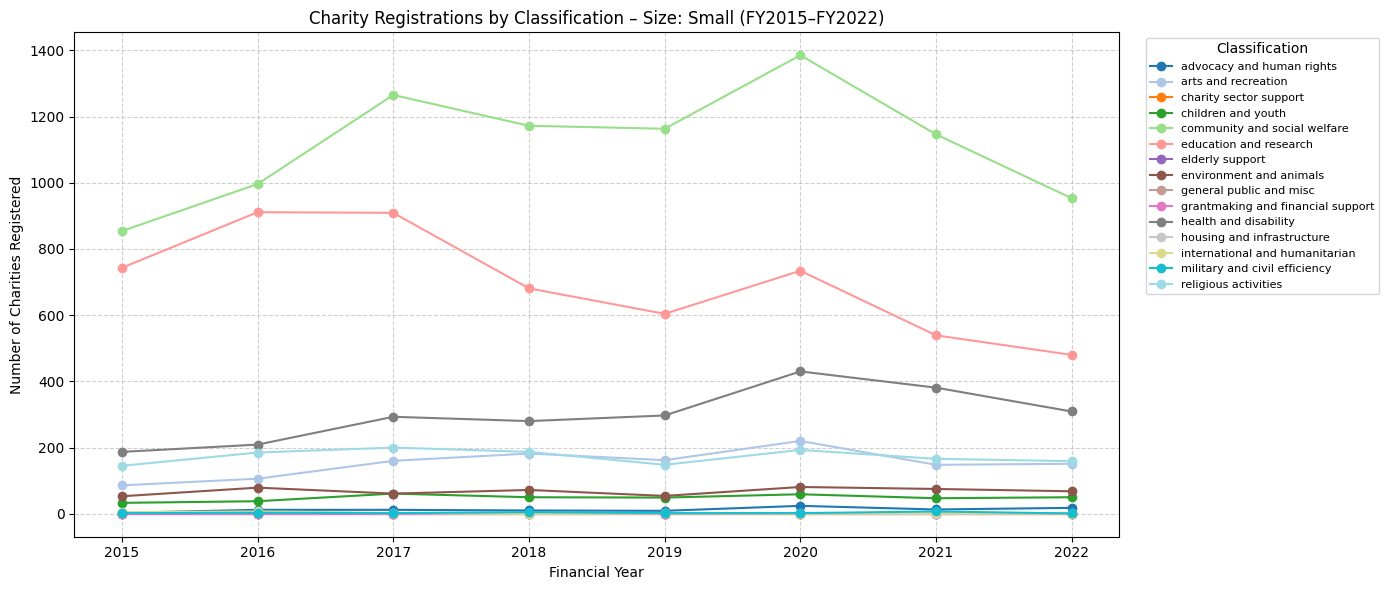

C:\Users\User\AppData\Local\Temp\ipykernel_21956\1201124502.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_series)


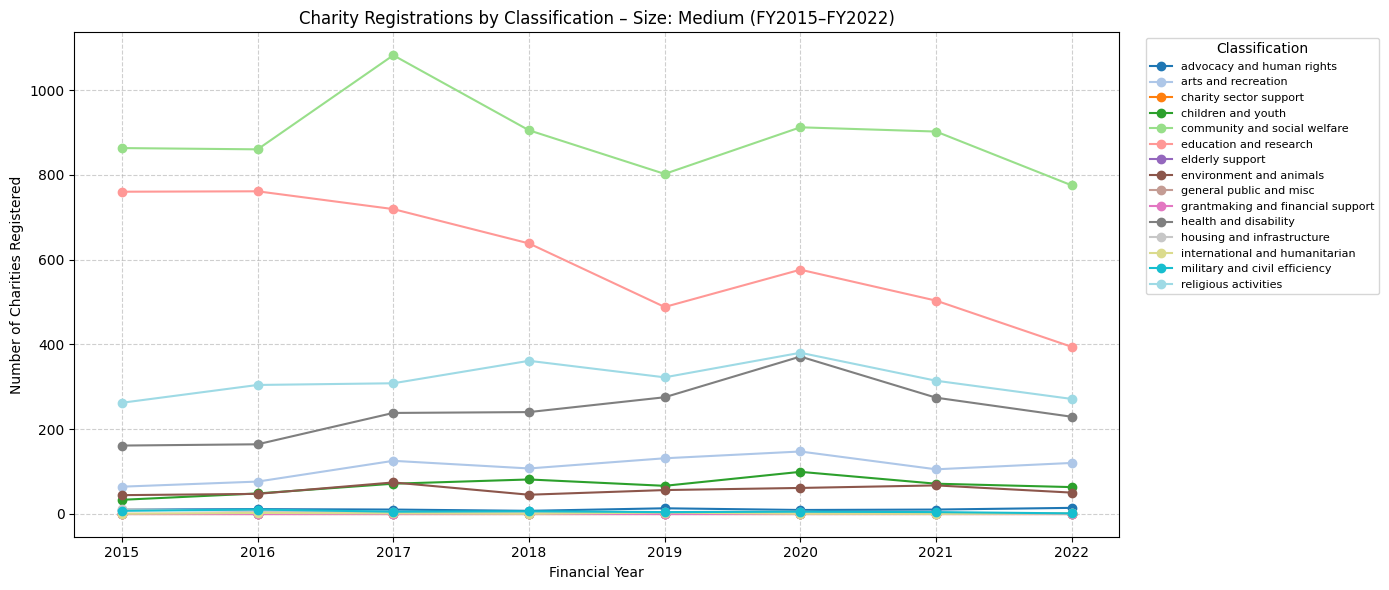

C:\Users\User\AppData\Local\Temp\ipykernel_21956\1201124502.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_series)


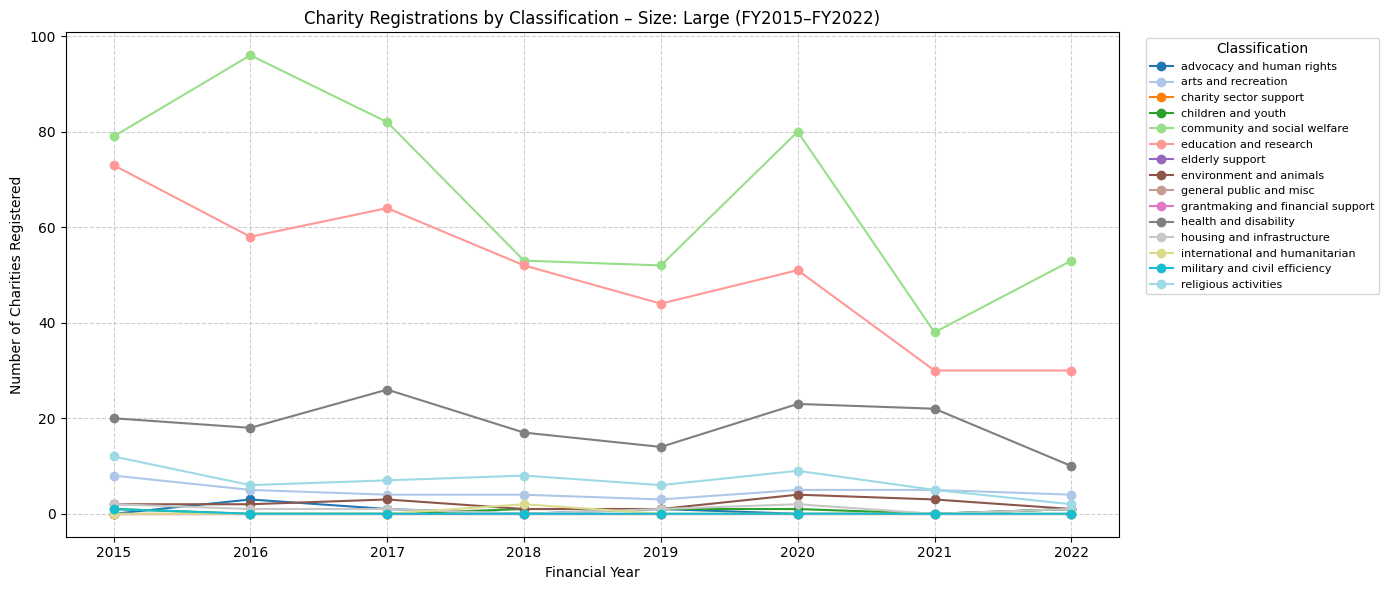

In [21]:
'''
Plot charity registrations by classification and size
This will show the number of registered charities categorised by classification 
and size for each financial year.
'''
# Select classification_* columns but exclude classification_description
class_cols = [
    c for c in dataset.columns
    if c.startswith('classification_') and c != 'classification_description'
]

# Ensure numeric FY and dummy values
dataset['registration_fy'] = pd.to_numeric(dataset['registration_fy'], errors='coerce').astype('Int64')
dataset[class_cols] = dataset[class_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Financial years range
fy_index = range(2015, 2023)  # FY2015–FY2022

# Loop over size categories
for size in ['Small', 'Medium', 'Large']:
    subset = dataset[
        (dataset['size_category'] == size) &
        (dataset['registration_fy'].between(2015, 2022))
    ].copy()

    # Sum classification dummies by FY
    summary = (
        subset
        .groupby('registration_fy')[class_cols]
        .sum()
        .reindex(fy_index, fill_value=0)
    )

    # Colour palette: unique colours for each classification
    num_series = len(summary.columns)
    if num_series <= 20:
        cmap = plt.cm.get_cmap('tab20', num_series)
        colors = [cmap(i) for i in range(num_series)]
    else:
        cmap = plt.cm.get_cmap('hsv', num_series)
        colors = [cmap(i) for i in range(num_series)]

    # Plot
    plt.figure(figsize=(14, 6))
    for i, col in enumerate(summary.columns):
        label_clean = col.replace('classification_', '').replace('_', ' ')
        plt.plot(
            summary.index, summary[col],
            marker='o', linewidth=1.5,
            label=label_clean, color=colors[i]
        )

    plt.title(f"Charity Registrations by Classification – Size: {size} (FY2015–FY2022)")
    plt.xlabel("Financial Year")
    plt.ylabel("Number of Charities Registered")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(list(fy_index))
    plt.legend(title="Classification", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()


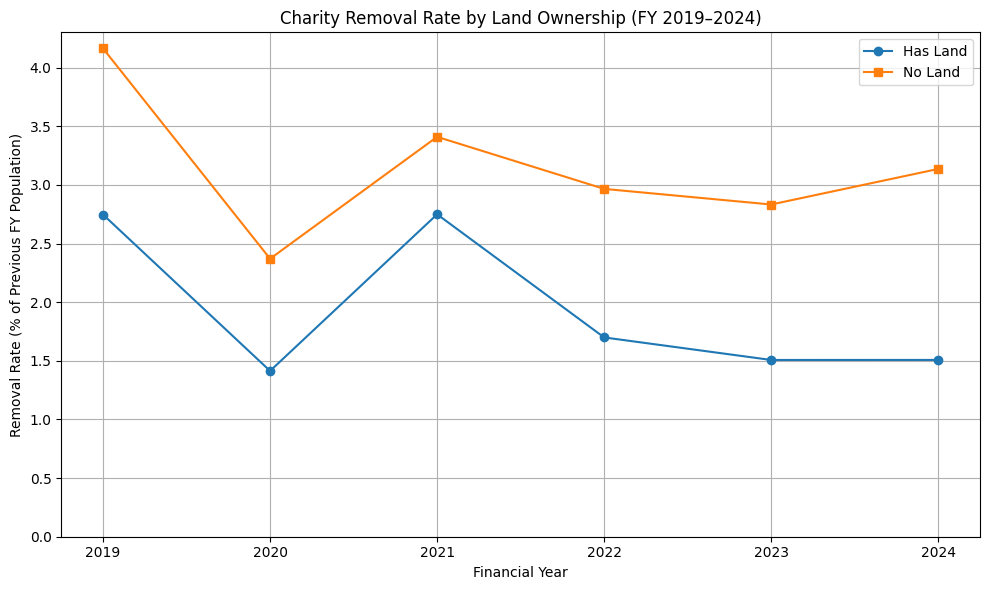

In [22]:
'''
Plot charity removal rates by land ownership
This will show the removal rates of charities that own land versus those that do not,
calculated as a percentage of the previous financial year's active population.
'''
# Ensure boolean column
dataset['charity_has_land'] = dataset['charity_has_land'].astype(bool)

# Define financial years
years = list(range(2019, 2025))

# Prepare dicts to hold results
removal_rates_with_land = []
removal_rates_without_land = []

for fy in years:
    # Define active population in the year before (for denominator)
    active_with_land = dataset[
        (dataset['charity_has_land'] == True) &
        (dataset['registration_fy'] <= fy - 1) &
        ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
    ]
    active_without_land = dataset[
        (dataset['charity_has_land'] == False) &
        (dataset['registration_fy'] <= fy - 1) &
        ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
    ]

    # Define removals in the current year (for numerator)
    removed_with_land = dataset[
        (dataset['charity_has_land'] == True) &
        (dataset['removal_fy'] == fy)
    ]
    removed_without_land = dataset[
        (dataset['charity_has_land'] == False) &
        (dataset['removal_fy'] == fy)
    ]

    # Compute rates
    rate_with_land = (len(removed_with_land) / len(active_with_land)) * 100 if len(active_with_land) > 0 else float('nan')
    rate_without_land = (len(removed_without_land) / len(active_without_land)) * 100 if len(active_without_land) > 0 else float('nan')

    # Append to lists
    removal_rates_with_land.append(rate_with_land)
    removal_rates_without_land.append(rate_without_land)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, removal_rates_with_land, marker='o', label='Has Land')
plt.plot(years, removal_rates_without_land, marker='s', label='No Land')

plt.title('Charity Removal Rate by Land Ownership (FY 2019–2024)')
plt.xlabel('Financial Year')
plt.ylabel('Removal Rate (% of Previous FY Population)')
plt.legend()
plt.grid(True)
plt.xticks(years)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


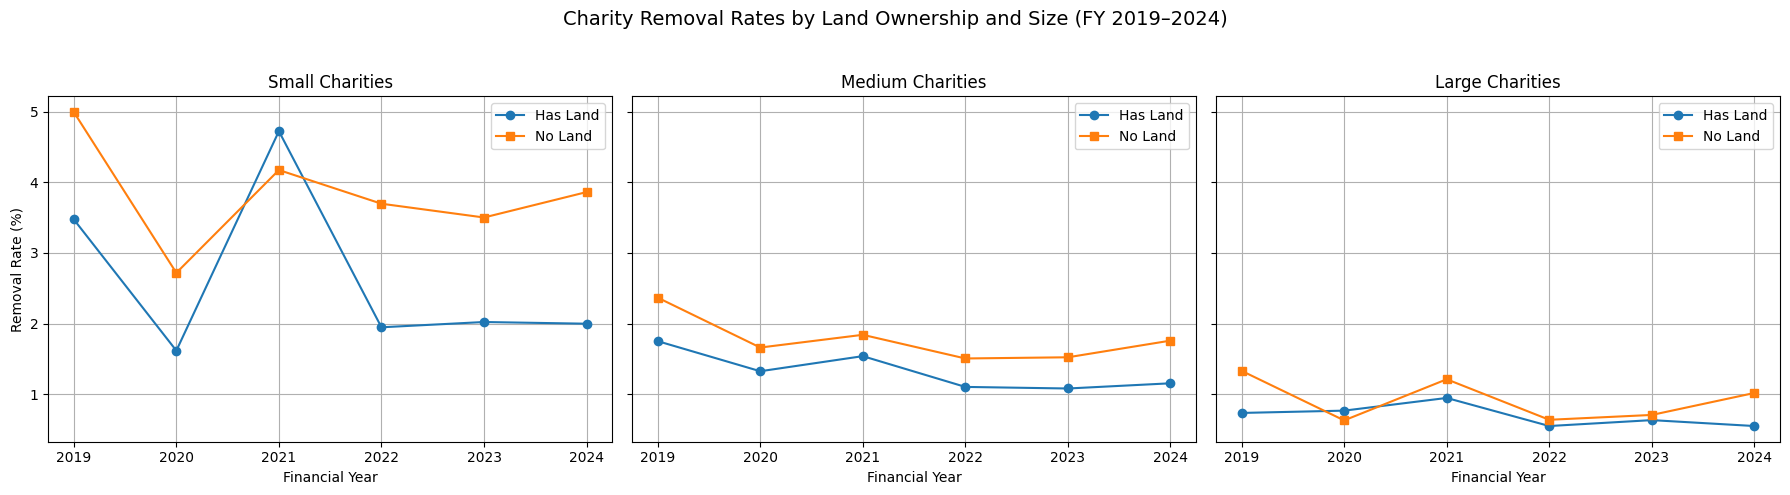

In [23]:
'''
Plot charity removal rates by land ownership and size category
This will show the removal rates of charities that own land versus those that do not,
categorised by size (Small, Medium, Large) for each financial year.
'''
# Ensure boolean and categorical formatting
dataset['charity_has_land'] = dataset['charity_has_land'].astype(bool)
dataset['size_category'] = dataset['size_category'].str.strip().str.title()

# Define financial years and size categories
years = list(range(2019, 2025))
sizes = ['Small', 'Medium', 'Large']

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, size in enumerate(sizes):
    removal_rates_with_land = []
    removal_rates_without_land = []

    for fy in years:
        # Define active charities in previous FY
        active_with_land = dataset[
            (dataset['charity_has_land'] == True) &
            (dataset['size_category'] == size) &
            (dataset['registration_fy'] <= fy - 1) &
            ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
        ]
        active_without_land = dataset[
            (dataset['charity_has_land'] == False) &
            (dataset['size_category'] == size) &
            (dataset['registration_fy'] <= fy - 1) &
            ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
        ]

        # Define removals in current FY
        removed_with_land = dataset[
            (dataset['charity_has_land'] == True) &
            (dataset['size_category'] == size) &
            (dataset['removal_fy'] == fy)
        ]
        removed_without_land = dataset[
            (dataset['charity_has_land'] == False) &
            (dataset['size_category'] == size) &
            (dataset['removal_fy'] == fy)
        ]

        # Calculate rates
        rate_with_land = (len(removed_with_land) / len(active_with_land)) * 100 if len(active_with_land) > 0 else float('nan')
        rate_without_land = (len(removed_without_land) / len(active_without_land)) * 100 if len(active_without_land) > 0 else float('nan')

        removal_rates_with_land.append(rate_with_land)
        removal_rates_without_land.append(rate_without_land)

    # Plot
    ax = axes[i]
    ax.plot(years, removal_rates_with_land, marker='o', label='Has Land')
    ax.plot(years, removal_rates_without_land, marker='s', label='No Land')
    ax.set_title(f'{size} Charities')
    ax.set_xlabel('Financial Year')
    if i == 0:
        ax.set_ylabel('Removal Rate (%)')
    ax.set_xticks(years)
    ax.grid(True)
    ax.legend()

plt.suptitle('Charity Removal Rates by Land Ownership and Size (FY 2019–2024)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
